# Part 14

## # Dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('../datasets/petr4_treinamento.csv')
df_train.shape, df_train.columns

((1245, 7),
 Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object'))

In [3]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [4]:
def _isnull(df):
    for c in df.columns:
        cnt = df[pd.isnull(df[c])].shape[0]
        if cnt != 0:
            print(f'# {c}: {cnt} rows')

In [5]:
_isnull(df_train)

# Open: 3 rows
# High: 3 rows
# Low: 3 rows
# Close: 3 rows
# Adj Close: 3 rows
# Volume: 3 rows


In [6]:
df_train.dropna(axis=0, inplace=True)
df_train.reset_index(inplace=True, drop=True)
df_train.shape

(1242, 7)

In [7]:
df_train.shape

(1242, 7)

DAYS BEFORE = 90

In [8]:
def daysbefore(df, days_before, col):
    feature = []
    target = []
    for i in range(days_before, df.shape[0]):
        slice_start = i - days_before
        slice_stop = i
        feature.append(df[col].iloc[slice_start:slice_stop].values)
        target.append(df[col].iloc[i])
    return np.array(feature), np.array(target)

In [9]:
x, y = daysbefore(df_train, 90, 'Open')

In [10]:
df_open_train = pd.DataFrame(data=x)
df_open_train['target'] = y
df_open_train.shape

(1152, 91)

In [11]:
df_open_train.tail()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,target
1147,13.64,13.70,13.78,13.78,13.87,13.93,13.76,13.79,13.53,13.85,...,15.36,15.65,15.10,15.05,15.16,15.18,15.21,15.31,15.75,15.75
1148,13.70,13.78,13.78,13.87,13.93,13.76,13.79,13.53,13.85,13.96,...,15.65,15.10,15.05,15.16,15.18,15.21,15.31,15.75,15.75,15.75
1149,13.78,13.78,13.87,13.93,13.76,13.79,13.53,13.85,13.96,14.57,...,15.10,15.05,15.16,15.18,15.21,15.31,15.75,15.75,15.75,15.99
1150,13.78,13.87,13.93,13.76,13.79,13.53,13.85,13.96,14.57,14.65,...,15.05,15.16,15.18,15.21,15.31,15.75,15.75,15.75,15.99,16.10
1151,13.87,13.93,13.76,13.79,13.53,13.85,13.96,14.57,14.65,15.02,...,15.16,15.18,15.21,15.31,15.75,15.75,15.75,15.99,16.10,16.10


In [12]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
x.shape, y.shape

((1152, 90, 1), (1152,))

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=42)

f'{xtrain.shape}, {ytrain.shape}, {xtest.shape}, {ytest.shape}'

'(864, 90, 1), (864,), (288, 90, 1), (288,)'

## # Model

In [15]:
from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dropout, Dense, LSTM, RNN

In [16]:
def model():
    clear_session()
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True,
                   input_shape=(xtrain.shape[1], xtrain.shape[2])))
    model.add(Dropout(rate=0.5))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(rate=0.5))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(rate=0.5))
    model.add(LSTM(units=50))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer='rmsprop', loss='mse', metrics='mae')
    print(model.summary())
    return model

In [17]:
clf = model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 90, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [32]:
clf.fit(x=xtrain, y=ytrain, validation_data=(xtest, ytest), epochs=200)

Epoch 1/200
27/27 [==============================] - 3s 112ms/step - loss: 83.9426 - mae: 7.9849 - val_loss: 43.4040 - val_mae: 5.4702
Epoch 2/200
27/27 [==============================] - 2s 60ms/step - loss: 35.6426 - mae: 5.0077 - val_loss: 29.2049 - val_mae: 4.5299
Epoch 3/200
27/27 [==============================] - 2s 60ms/step - loss: 26.6634 - mae: 4.2547 - val_loss: 19.5740 - val_mae: 3.5609
Epoch 4/200
27/27 [==============================] - 2s 61ms/step - loss: 17.8806 - mae: 3.3616 - val_loss: 13.3232 - val_mae: 2.8179
Epoch 5/200
27/27 [==============================] - 2s 61ms/step - loss: 13.0012 - mae: 2.8209 - val_loss: 9.4223 - val_mae: 2.2912
Epoch 6/200
27/27 [==============================] - 2s 61ms/step - loss: 10.6161 - mae: 2.5686 - val_loss: 7.6598 - val_mae: 2.1310
Epoch 7/200
27/27 [==============================] - 2s 63ms/step - loss: 9.1155 - mae: 2.3756 - val_loss: 4.8843 - val_mae: 1.5982
Epoch 8/200
27/27 [==============================] - 2s 60ms/step

27/27 [==============================] - 2s 63ms/step - loss: 3.9499 - mae: 1.5260 - val_loss: 0.6090 - val_mae: 0.5796
Epoch 124/200
27/27 [==============================] - 2s 62ms/step - loss: 3.9465 - mae: 1.5532 - val_loss: 0.7535 - val_mae: 0.7035
Epoch 125/200
27/27 [==============================] - 2s 62ms/step - loss: 4.2140 - mae: 1.5829 - val_loss: 0.5697 - val_mae: 0.5839
Epoch 126/200
27/27 [==============================] - 2s 59ms/step - loss: 4.3364 - mae: 1.6288 - val_loss: 0.4261 - val_mae: 0.4590
Epoch 127/200
27/27 [==============================] - 2s 63ms/step - loss: 4.0496 - mae: 1.5413 - val_loss: 1.1036 - val_mae: 0.9108
Epoch 128/200
27/27 [==============================] - 2s 65ms/step - loss: 3.9447 - mae: 1.5224 - val_loss: 0.7268 - val_mae: 0.6862
Epoch 129/200
27/27 [==============================] - 2s 68ms/step - loss: 3.4023 - mae: 1.4452 - val_loss: 0.8164 - val_mae: 0.7160
Epoch 130/200
27/27 [==============================] - 2s 72ms/step - loss: 

## # Evaluation

In [33]:
pred = clf.predict(xtest)

In [34]:
ytest.shape, pred.shape

((288,), (288, 1))

In [35]:
ytest.mean() - pred.mean()

0.3080278885837142

In [36]:
ytest.std() - pred.std()

0.1482859928835918

### ## Test data

In [37]:
df_test = pd.read_csv('../datasets/petr4_teste.csv')
df_test.shape, df_test.columns

((22, 7),
 Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object'))

In [38]:
df_test.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
17,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0
18,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500
19,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200
20,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000
21,2018-01-31,19.740000,19.930000,19.680000,19.700001,19.660681,41576600


In [39]:
df_complete = pd.concat(objs=[df_train, df_test], axis=0)
df_complete.reset_index(inplace=True, drop=True)
df_complete.shape

(1264, 7)

In [40]:
df_complete.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1259,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0.0
1260,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500.0
1261,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200.0
1262,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000.0
1263,2018-01-31,19.740000,19.930000,19.680000,19.700001,19.660681,41576600.0


In [41]:
x, y = daysbefore(df_complete, 90, 'Open')

In [42]:
x.shape, y.shape

((1174, 90), (1174,))

In [43]:
df_open_test = pd.DataFrame(data=x)
df_open_test['target'] = y
df_open_test.shape

(1174, 91)

In [44]:
df_open_test.tail()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,target
1169,15.25,15.85,15.60,15.79,15.86,15.70,15.37,15.50,15.19,15.60,...,17.040001,17.320000,17.350000,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000
1170,15.85,15.60,15.79,15.86,15.70,15.37,15.50,15.19,15.60,15.90,...,17.320000,17.350000,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001
1171,15.60,15.79,15.86,15.70,15.37,15.50,15.19,15.60,15.90,15.88,...,17.350000,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001,19.670000
1172,15.79,15.86,15.70,15.37,15.50,15.19,15.60,15.90,15.88,15.66,...,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001,19.670000,19.770000
1173,15.86,15.70,15.37,15.50,15.19,15.60,15.90,15.88,15.66,15.61,...,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001,19.670000,19.770000,19.740000


In [45]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
x.shape, y.shape

((1174, 90, 1), (1174,))

In [46]:
pred = clf.predict(x)

In [47]:
pred.shape, y.shape

((1174, 1), (1174,))

In [48]:
y.mean() - pred.mean()

0.31430791268125624

In [49]:
y.std() - pred.std()

0.12066164923959555

In [50]:
import matplotlib.pyplot as plt

%matplotlib notebook

<IPython.core.display.Javascript object>


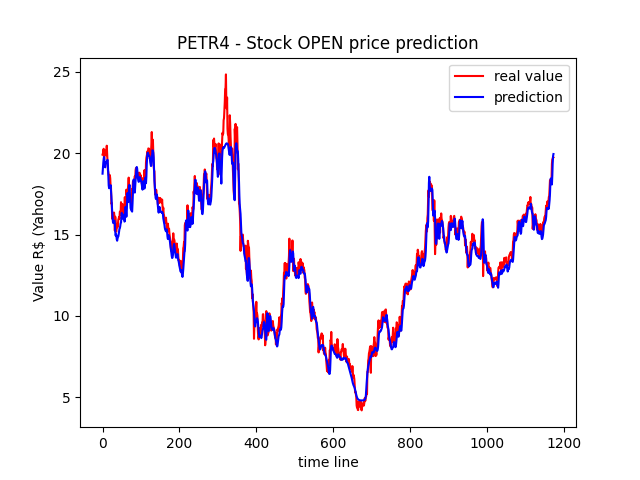

In [51]:
plt.plot(y, color='red', label='real value')
plt.plot(pred, color='blue', label='prediction')
plt.title('PETR4 - Stock OPEN price prediction')
plt.xlabel('time line')
plt.ylabel('Value R$ (Yahoo)')
plt.legend()
plt.show()

## ## Multiple inputs & Callbacks

In [18]:
df_train.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [19]:
x_m, _ = daysbefore(df_train, 90, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
y_m = df_train['Open'][90:]
x_m.shape, y_m.shape

((1152, 90, 6), (1152,))

In [20]:
xtrain_m, xtest_m, ytrain_m, ytest_m = train_test_split(x_m, y_m,
                                                        test_size=0.25, random_state=42)

f'{xtrain_m.shape}, {ytrain_m.shape}, {xtest_m.shape}, {ytest_m.shape}'

'(864, 90, 6), (864,), (288, 90, 6), (288,)'

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [22]:
es = EarlyStopping(monitor='loss', min_delta=1e-20, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1)
mcp = ModelCheckpoint(monitor='loss', filepath='sess_14-weights.h5.',
                      save_best_only=True, verbose=1)

In [23]:
def model_m():
    clear_session()
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True,
                   input_shape=(xtrain_m.shape[1], xtrain_m.shape[2])))
    model.add(Dropout(rate=0.25))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(rate=0.25))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(rate=0.25))
    model.add(LSTM(units=50))
    model.add(Dropout(rate=0.25))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics='mean_absolute_error')
#     print(model.summary())
    return model

clf_m = model_m()

# clf_m.fit(x=xtrain_m, y=xtrain_m, validation_data=(xtest_m, ytest_m), epochs=200,
#          callbacks=[es, rlr, mcp])
clf_m.fit(x=xtrain_m, y=xtrain_m, validation_data=(xtest_m, ytest_m), epochs=200)

Epoch 1/200


ValueError: in user code:

    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:748 train_step
        loss = self.compiled_loss(
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1195 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:10398 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3477 _create_op_internal
        ret = Operation(
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/hbrandao/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 32 and 90 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential/dense/BiasAdd, IteratorGetNext:1)' with input shapes: [32,1], [32,90,6].


### ## Evaluation

In [74]:
pred_m = clf_m.predict(xtest_m)

In [75]:
pred_m.shape, ytest_m.shape

((288, 90, 1), (288,))

In [76]:
ytest_m.mean() - pred_m.mean()

-6.333263729763454

In [77]:
ytest_m.std() - pred_m.std()

3.628266132769866

### ## Test data

In [78]:
x_m, _ = daysbefore(df_complete, 90, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
y_m = df_complete['Open'][90:]
x_m.shape, y_m.shape

((1174, 90, 6), (1174,))

In [79]:
pred_m = clf_m.predict(x_m) 

In [83]:
pred_m.shape, y_m.shape, 

((1174, 90, 1), (1174,))

In [84]:
y_m.mean() - pred_m.mean()

-6.400171533729877

In [85]:
y_m.std() - pred_m.std()

3.482211479555925

<IPython.core.display.Javascript object>


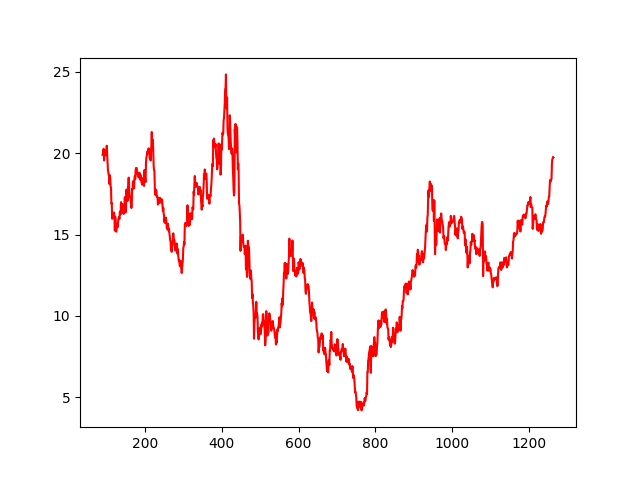

ValueError: x and y can be no greater than 2-D, but have shapes (1174,) and (1174, 90, 1)

In [86]:
plt.plot(y_m, color='red', label='real value')
plt.plot(pred_m, color='blue', label='prediction')
plt.title('PETR4 - Stock OPEN price prediction (Multiple inputs)')
plt.xlabel('time line')
plt.ylabel('Value R$ (Yahoo)')
plt.legend()
plt.show()

### ## All results

In [ ]:
plt.plot(df_complete['Open'][90:], color='red', label='real value')
plt.plot(pred, color='blue', label='prediction')
plt.plot(pred_m, color='green', label='prediction multiple inputs')
plt.title('PETR4 - Stock OPEN price prediction (Multiple inputs)')
plt.xlabel('time line')
plt.ylabel('Value R$ (Yahoo)')
plt.legend()
plt.show()